In [ ]:
# Clone the repository from GitHub
!git clone https://github.com/dungdinhhaha/ClassifyCell /content/PhatHienTeBao
%cd /content/PhatHienTeBao

In [ ]:
# Mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')
# Đảm bảo các file sau nằm trong thư mục này trên Google Drive:
## /content/drive/MyDrive/PhatHienTeBao/SIMPLE_CELL_DETECTION.ipynb
## /content/drive/MyDrive/PhatHienTeBao/TRAIN_CLASSIFIER_FROM_FOLDERS.ipynb
## /content/drive/MyDrive/PhatHienTeBao/best_cytology_model.keras
## /content/drive/MyDrive/PhatHienTeBao/images/
## /content/drive/MyDrive/PhatHienTeBao/sample.svs

Mounted at /content/drive


In [2]:
!apt-get install -y openslide-tools
!pip install -q opencv-python pillow openslide-python

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import json
from pathlib import Path
from glob import glob

import tensorflow as tf
print(f'✅ TensorFlow: {tf.__version__}')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 104 kB of archives.
After this operation, 297 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 openslide-tools amd64 3.4.1+dfsg-5build1 [13.8 kB]
Fetched 104 kB in 1s (79.9 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools

## 2️⃣ LOAD MODEL PHÂN LOẠI

In [ ]:
# Load model phân loại tế bào
classification_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/PhatHienTeBao/best_cytology_model.keras' # Đường dẫn model trên Google Drive
)

# Định nghĩa nhãn
label_map = {
    0: "back_ground",
    1: 'ascus',
    2: 'asch',
    3: 'lsil',
    4: 'hsil',
    5: 'scc',
    6: 'agc',
    7: 'trichomonas',
    8: 'candida',
    9: 'flora',
    10: 'herps',
    11: 'actinomyces',
}

print('✅ Model đã được load!')
print(f'📊 Số lượng class: {len(label_map)}')

✅ Model đã được load!
📊 Số lượng class: 12


Sau khi Drive được kết nối, bạn sẽ thấy thư mục `drive` trong `/content/drive`.

In [4]:
# ========== CẤU HÌNH NGƯỠNG ==========
# Thay đổi giá trị này để điều chỉnh độ nhạy phát hiện bất thường

ABNORMAL_CONFIDENCE_THRESHOLD = 0.7  # Chỉ coi là bất thường nếu confidence >= 70%

# Có thể thử các giá trị:
# 0.5 → Phát hiện nhiều hơn (ít nghiêm ngặt)
# 0.7 → Cân bằng (khuyến nghị)
# 0.85 → Chỉ những trường hợp rất chắc chắn

print(f'⚙️  Ngưỡng phát hiện bất thường: {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}%')
print(f'   → Tế bào có confidence < {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}% sẽ được coi là "Uncertain/Normal"')

⚙️  Ngưỡng phát hiện bất thường: 70%
   → Tế bào có confidence < 70% sẽ được coi là "Uncertain/Normal"


## ⚙️ CẤU HÌNH NGƯỠNG PHÁT HIỆN

**Vấn đề:** Model không có class "normal" nên sẽ dự đoán tất cả tế bào là bất thường

**Giải pháp:** Dùng ngưỡng confidence để lọc:
- **Confidence cao (>0.7)**: Chắc chắn là bất thường ✅
- **Confidence thấp (<0.7)**: Không chắc → coi như "bình thường/không rõ" ⚠️

## 3️⃣ HÀM PHÁT HIỆN TẾ BÀO

In [5]:
def detect_cells_in_image(image, min_area=500, max_area=50000):
    """
    Phát hiện các tế bào trong ảnh

    Args:
        image: Ảnh RGB (numpy array hoặc đường dẫn file)
        min_area: Diện tích tối thiểu của tế bào (pixels)
        max_area: Diện tích tối đa của tế bào (pixels)

    Returns:
        cells: List các dict chứa thông tin tế bào
    """
    # Đọc ảnh nếu là đường dẫn
    if isinstance(image, str):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Chuyển sang grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Làm mờ để giảm nhiễu
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold tự động (Otsu)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological operations để làm sạch
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Tìm contours (viền tế bào)
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cells = []
    for contour in contours:
        area = cv2.contourArea(contour)

        # Lọc theo diện tích
        if min_area < area < max_area:
            # Tính bounding box
            x, y, w, h = cv2.boundingRect(contour)

            # Tính tâm tế bào
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
            else:
                cx, cy = x + w//2, y + h//2

            cells.append({
                'bbox': (x, y, w, h),
                'center': (cx, cy),
                'area': area
            })

    return cells

print('✅ Hàm detect tế bào đã sẵn sàng!')

✅ Hàm detect tế bào đã sẵn sàng!


In [6]:
def detect_cells_enhanced(image, min_area=200, max_area=90000, blur_ksize=5, clahe_clip=2.0):
    """
    Phát hiện tế bào nhạy hơn (tăng tương phản + adaptive threshold)
    - Dùng CLAHE để nổi bật biên tế bào
    - Kết hợp adaptive threshold và Otsu
    """
    # Đọc ảnh nếu là đường dẫn
    if isinstance(image, str):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Tăng tương phản kênh sáng
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge((l_eq, a, b))
    img_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)

    gray = cv2.cvtColor(img_eq, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)

    # Adaptive threshold (nhạy với vùng sáng tối không đều)
    adaptive = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 5
    )
    # Otsu bổ sung
    _, otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    mask = cv2.bitwise_or(adaptive, otsu)

    # Morphology để gộp vùng
    kernel = np.ones((3, 3), np.uint8)
    clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.dilate(clean, kernel, iterations=1)

    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cells = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            x, y, w, h = cv2.boundingRect(contour)
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
            else:
                cx, cy = x + w//2, y + h//2
            cells.append({
                'bbox': (x, y, w, h),
                'center': (cx, cy),
                'area': area
            })
    return cells

print('✅ Hàm detect nâng cao (CLAHE + adaptive threshold) đã sẵn sàng!')

✅ Hàm detect nâng cao (CLAHE + adaptive threshold) đã sẵn sàng!


In [7]:
def nms_boxes(boxes, scores, iou_thresh=0.3):
    """Non-maximum suppression cho bbox dạng (x,y,w,h)."""
    if len(boxes) == 0:
        return []
    boxes_np = np.array(boxes)
    scores_np = np.array(scores)
    x1 = boxes_np[:, 0]
    y1 = boxes_np[:, 1]
    x2 = boxes_np[:, 0] + boxes_np[:, 2]
    y2 = boxes_np[:, 1] + boxes_np[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores_np.argsort()[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter + 1e-6)
        inds = np.where(iou <= iou_thresh)[0]
        order = order[inds + 1]
    return keep

def detect_cells_combo(image, min_area=120, max_area=120000, iou_thresh=0.3,
                       blur_ksize=5, clahe_clip=2.0, adaptive_block=25, adaptive_C=7):
    """
    Kết hợp hai detector (basic + enhanced) rồi NMS để tăng recall mà không quá nhiều trùng.
    """
    # Enhanced
    cells_enh = detect_cells_enhanced(
        image,
        min_area=min_area,
        max_area=max_area,
        blur_ksize=blur_ksize,
        clahe_clip=clahe_clip
    )
    # Basic
    cells_basic = detect_cells_in_image(
        image,
        min_area=min_area,
        max_area=max_area
    )

    all_boxes = []
    all_scores = []
    all_cells = []

    for c in cells_enh:
        all_boxes.append(c['bbox'])
        all_scores.append(0.8)  # ưu tiên enhanced
        all_cells.append(c)
    for c in cells_basic:
        all_boxes.append(c['bbox'])
        all_scores.append(0.5)  # basic trọng số thấp hơn
        all_cells.append(c)

    keep_idx = nms_boxes(all_boxes, all_scores, iou_thresh=iou_thresh)
    merged = [all_cells[i] for i in keep_idx]
    return merged

print('✅ Hàm detect_combo (kết hợp + NMS) đã sẵn sàng!')

✅ Hàm detect_combo (kết hợp + NMS) đã sẵn sàng!


## 4️⃣ XỬ LÝ TOÀN BỘ FOLDER ẢNH

In [ ]:
# Thay đổi đường dẫn folder chứa ảnh của bạn
image_folder = '/content/drive/MyDrive/PhatHienTeBao/images'  # Đường dẫn thư mục ảnh trên Google Drive

if os.path.exists(image_folder):
    # Chạy phát hiện và phân loại
    results = process_image_folder(
        image_folder=image_folder,
        classification_model=classification_model,
        output_dir='./cell_detection_results'
    )

    # Thống kê kết quả
    print('\n📊 THỐNG KÊ KẾT QUẢ:')
    print(f'   Tổng số tế bào phát hiện: {len(results)}')

    from collections import Counter

    # Thống kê theo trạng thái
    status_counts = Counter([r['status'] for r in results])
    print(f'\n   📌 Theo trạng thái:')
    print(f'      🔴 Bất thường (chắc chắn, conf >= {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}%): {status_counts.get("abnormal", 0)} tế bào')
    print(f'      ⚪ Không chắc chắn (conf < {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}%): {status_counts.get("uncertain", 0)} tế bào')
    print(f'      🟢 Bình thường: {status_counts.get("normal", 0)} tế bào')

    # Thống kê theo loại
    class_counts = Counter([r['label'] for r in results])

    print('\n   📌 Phân bố theo loại tế bào (tất cả):')
    for label, count in class_counts.most_common():
        percentage = 100 * count / len(results)
        print(f'      {label:15s}: {count:4d} tế bào ({percentage:5.1f}%)')

    # Tế bào bất thường THẬT (confidence cao)
    truly_abnormal = [r for r in results if r['is_truly_abnormal']]
    uncertain = [r for r in results if r['status'] == 'uncertain']

    print(f'\n   ⚠️  BẤT THƯỜNG THỰC TẾ (confidence >= {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}%): {len(truly_abnormal)} tế bào')
    print(f'   ❓ Không chắc chắn (có thể bình thường): {len(uncertain)} tế bào')

    if len(results) > 0:
        print(f'\n   🎯 Tỷ lệ bất thường chắc chắn: {100*len(truly_abnormal)/len(results):.1f}%')
        print(f'   💡 Gợi ý: Nếu thấy quá nhiều/ít bất thường, điều chỉnh ABNORMAL_CONFIDENCE_THRESHOLD')

else:
    print(f'❌ Không tìm thấy folder: {image_folder}')
    print('   Vui lòng thay đổi đường dẫn folder chứa ảnh đã cắt của bạn')

✅ Hàm xử lý folder đã sẵn sàng!


## 5️⃣ CHẠY PHÁT HIỆN VÀ PHÂN LOẠI

In [21]:
# Thay đổi đường dẫn folder chứa ảnh của bạn
image_folder = '/content/drive/MyDrive/ComparisonDetector/cut_image.png'

if os.path.exists(image_folder):
    # Chạy phát hiện và phân loại
    results = process_image_folder(
        image_folder=image_folder,
        classification_model=classification_model,
        output_dir='./cell_detection_results'
    )

    # Thống kê kết quả
    print('\n📊 THỐNG KÊ KẾT QUẢ:')
    print(f'   Tổng số tế bào phát hiện: {len(results)}')

    from collections import Counter

    # Thống kê theo trạng thái
    status_counts = Counter([r['status'] for r in results])
    print(f'\n   📌 Theo trạng thái:')
    print(f'      🔴 Bất thường (chắc chắn, conf >= {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}%): {status_counts.get("abnormal", 0)} tế bào')
    print(f'      ⚪ Không chắc chắn (conf < {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}%): {status_counts.get("uncertain", 0)} tế bào')
    print(f'      🟢 Bình thường: {status_counts.get("normal", 0)} tế bào')

    # Thống kê theo loại
    class_counts = Counter([r['label'] for r in results])

    print('\n   📌 Phân bố theo loại tế bào (tất cả):')
    for label, count in class_counts.most_common():
        percentage = 100 * count / len(results)
        print(f'      {label:15s}: {count:4d} tế bào ({percentage:5.1f}%)')

    # Tế bào bất thường THẬT (confidence cao)
    truly_abnormal = [r for r in results if r['is_truly_abnormal']]
    uncertain = [r for r in results if r['status'] == 'uncertain']

    print(f'\n   ⚠️  BẤT THƯỜNG THỰC TẾ (confidence >= {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}%): {len(truly_abnormal)} tế bào')
    print(f'   ❓ Không chắc chắn (có thể bình thường): {len(uncertain)} tế bào')

    if len(results) > 0:
        print(f'\n   🎯 Tỷ lệ bất thường chắc chắn: {100*len(truly_abnormal)/len(results):.1f}%')
        print(f'   💡 Gợi ý: Nếu thấy quá nhiều/ít bất thường, điều chỉnh ABNORMAL_CONFIDENCE_THRESHOLD')

else:
    print(f'❌ Không tìm thấy folder: {image_folder}')
    print('   Vui lòng thay đổi đường dẫn folder chứa ảnh đã cắt của bạn')

🔬 Tìm thấy 0 ảnh trong folder: /content/drive/MyDrive/ComparisonDetector/sample.svs
⚙️  Ngưỡng confidence: 70% (chỉ báo bất thường khi chắc chắn)


✅ Hoàn thành! Tổng cộng phát hiện 0 tế bào từ 0 ảnh
💾 Kết quả đã lưu vào: ./cell_detection_results/detection_results.json

📊 THỐNG KÊ KẾT QUẢ:
   Tổng số tế bào phát hiện: 0

   📌 Theo trạng thái:
      🔴 Bất thường (chắc chắn, conf >= 70%): 0 tế bào
      ⚪ Không chắc chắn (conf < 70%): 0 tế bào
      🟢 Bình thường: 0 tế bào

   📌 Phân bố theo loại tế bào (tất cả):

   ⚠️  BẤT THƯỜNG THỰC TẾ (confidence >= 70%): 0 tế bào
   ❓ Không chắc chắn (có thể bình thường): 0 tế bào


## 6️⃣ HIỂN THỊ MỘT SỐ KẾT QUẢ

In [10]:
# Hiển thị một ảnh mẫu với các tế bào được detect
if 'results' in locals() and len(results) > 0:
    # Lấy ảnh đầu tiên có tế bào
    sample_img_name = results[0]['source_image']
    sample_img_path = os.path.join(image_folder, sample_img_name)

    # Đọc ảnh
    img = cv2.imread(sample_img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_draw = img_rgb.copy()

    # Vẽ bounding box lên các tế bào
    cells_in_this_image = [r for r in results if r['source_image'] == sample_img_name]

    for cell in cells_in_this_image:
        x, y, w, h = cell['x'], cell['y'], cell['width'], cell['height']

        # Màu theo trạng thái (có xét confidence)
        if cell['status'] == 'abnormal':  # Bất thường chắc chắn
            color = (255, 0, 0)  # Đỏ
            thickness = 3
        elif cell['status'] == 'uncertain':  # Không chắc chắn
            color = (255, 165, 0)  # Cam
            thickness = 2
        else:  # Normal
            color = (0, 255, 0)  # Xanh lá
            thickness = 2

        # Vẽ bounding box
        cv2.rectangle(img_draw, (x, y), (x+w, y+h), color, thickness)

        # Ghi nhãn
        label_text = f"{cell['label']} ({cell['confidence']:.2f})"
        cv2.putText(img_draw, label_text, (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Hiển thị
    plt.figure(figsize=(15, 15))
    plt.imshow(img_draw)

    # Đếm theo trạng thái
    abnormal_count = len([c for c in cells_in_this_image if c['status'] == 'abnormal'])
    uncertain_count = len([c for c in cells_in_this_image if c['status'] == 'uncertain'])
    normal_count = len([c for c in cells_in_this_image if c['status'] == 'normal'])

    title = f'{sample_img_name}\n'
    title += f'🔴 Bất thường: {abnormal_count} | '
    title += f'🟠 Không chắc: {uncertain_count} | '
    title += f'🟢 Bình thường: {normal_count}'

    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    print(f'✅ Ảnh mẫu: {sample_img_name}')
    print(f'   Tổng tế bào: {len(cells_in_this_image)}')

## 7️⃣ HIỂN THỊ TẾ BÀO BẤT THƯỜNG

In [11]:
# Hiển thị các tế bào bất thường CHẮC CHẮN
if 'results' in locals() and len(results) > 0:
    # CHỈ LẤY TẾ BÀO BẤT THƯỜNG THẬT (confidence cao)
    abnormal_cells = [r for r in results if r['is_truly_abnormal']]

    if len(abnormal_cells) > 0:
        # Sắp xếp theo confidence
        abnormal_sorted = sorted(abnormal_cells, key=lambda x: x['confidence'], reverse=True)

        # Hiển thị top 12
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        axes = axes.flatten()

        for idx, cell in enumerate(abnormal_sorted[:12]):
            img_path = f'./cell_detection_results/cells/cell_{cell["cell_id"]}_{cell["label"]}_{cell["confidence"]:.2f}.jpg'

            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                axes[idx].imshow(img)
                axes[idx].set_title(
                    f'{cell["label"]}\n✅ Conf: {cell["confidence"]:.3f}\nFrom: {cell["source_image"]}',
                    fontsize=9, color='darkred', fontweight='bold'
                )
                axes[idx].axis('off')

        # Ẩn subplot trống
        for idx in range(len(abnormal_sorted), 12):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.suptitle(f'🔴 TẾ BÀO BẤT THƯỜNG CHẮC CHẮN (Tổng: {len(abnormal_cells)}, Ngưỡng: {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}%)',
                     fontsize=15, fontweight='bold', y=1.0)
        plt.show()

        print(f'\n✅ Đã hiển thị {min(12, len(abnormal_cells))} tế bào bất thường chắc chắn')
        print(f'   (Chỉ những tế bào có confidence >= {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}%)')
    else:
        print('✅ Không phát hiện tế bào bất thường chắc chắn!')
        print(f'   (Không có tế bào nào có confidence >= {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}%)')
        print(f'   💡 Nếu muốn nhiều kết quả hơn, giảm ABNORMAL_CONFIDENCE_THRESHOLD')

    # Hiển thị thêm các tế bào KHÔNG CHẮC CHẮN nếu có
    uncertain = [r for r in results if r['status'] == 'uncertain']
    if len(uncertain) > 0:
        print(f'\n⚠️  Có {len(uncertain)} tế bào không chắc chắn (confidence < {ABNORMAL_CONFIDENCE_THRESHOLD*100:.0f}%)')
        print(f'   → Model nghĩ là bất thường nhưng không tự tin')
        print(f'   → Xem trong folder: ./cell_detection_results/uncertain/')

## 8️⃣ XUẤT KẾT QUẢ RA CSV

In [12]:
import pandas as pd

if 'results' in locals() and len(results) > 0:
    # Chuyển sang DataFrame
    df = pd.DataFrame(results)

    # Lưu ra CSV
    csv_file = './cell_detection_results/detection_results.csv'
    df.to_csv(csv_file, index=False, encoding='utf-8-sig')

    print(f'✅ Đã lưu kết quả ra: {csv_file}')

    # Hiển thị preview
    print('\n📊 Preview 10 dòng đầu:')
    display(df.head(10))

    # Thống kê theo loại
    print('\n📈 Thống kê theo loại tế bào:')
    display(df.groupby('label').agg({
        'cell_id': 'count',
        'confidence': 'mean',
        'area': 'mean'
    }).rename(columns={
        'cell_id': 'Số lượng',
        'confidence': 'Confidence TB',
        'area': 'Diện tích TB'
    }).sort_values('Số lượng', ascending=False))

## 9️⃣ TẠO BÁO CÁO

In [13]:
def generate_report(results, output_file='./cell_detection_results/report.txt', min_confidence=0.70):
    """
    Tạo báo cáo tổng hợp
    """
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('='*80 + '\n')
        f.write('BÁO CÁO PHÁT HIỆN VÀ PHÂN LOẠI TẾ BÀO CỔ TỬ CUNG (PARALLEL MODE - 6 THREADS)\n')
        f.write('='*80 + '\n\n')

        # Tổng quan
        num_images = len(set([r['source_image'] for r in results])) if 'source_image' in results[0] else 1 # Adjust for SVS where source_image might not be per cell
        f.write(f'Số ảnh đã xử lý: {num_images}\n')
        f.write(f'Tổng số tế bào phát hiện: {len(results)}\n')
        # f.write(f'Trung bình tế bào/ảnh: {len(results)/num_images:.1f}\n') # Not directly applicable for SVS without explicit image count
        f.write(f'Ngưỡng confidence tối thiểu: {min_confidence*100:.0f}%\n\n')

        # Thống kê theo trạng thái
        from collections import Counter
        status_counts = Counter([r['status'] for r in results])

        f.write('THỐNG KÊ THEO TRẠNG THÁI:\n')
        f.write('-'*80 + '\n')
        f.write(f'🔴 Bất thường (chắc chắn):        {status_counts.get("abnormal", 0):5d} tế bào\n')
        f.write(f'🟠 Không chắc chắn (cần xem lại): {status_counts.get("uncertain", 0):5d} tế bào\n')
        f.write(f'🟢 Bình thường:                   {status_counts.get("normal", 0):5d} tế bào\n\n')

        # Phân bố theo loại
        class_counts = Counter([r['label'] for r in results])

        f.write('PHÂN BỐ THEO LOẠI TẾ BÀO:\n')
        f.write('-'*80 + '\n')
        for label, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = 100 * count / len(results)
            f.write(f'{label:20s}: {count:5d} tế bào ({percentage:5.2f}%)\n')

        # Tế bào bất thường THẬT
        truly_abnormal = [r for r in results if r['is_truly_abnormal']]

        f.write('\n' + '='*80 + '\n')
        f.write(f'TẾ BÀO BẤT THƯỜNG CHẮC CHẮN: {len(truly_abnormal)}\n')
        f.write(f'(Confidence >= {min_confidence*100:.0f}%)\n')
        f.write('='*80 + '\n\n')

        if len(truly_abnormal) > 0:
            abnormal_sorted = sorted(truly_abnormal, key=lambda x: x['confidence'], reverse=True)

            f.write('TOP 20 TẾ BÀO BẤT THƯỜNG:\n')
            f.write('-'*80 + '\n')

            for idx, cell in enumerate(abnormal_sorted[:20], 1):
                f.write(f'{idx:3d}. ID: {cell["cell_id"]:5d} | '
                       f'Loại: {cell["label"]:15s} | '
                       f'Conf: {cell["confidence"]:.3f} | '
                       f'From: {cell.get("source_image", "SVS")}\n') # Adjust for SVS

        # Tế bào không chắc chắn
        uncertain = [r for r in results if r['status'] == 'uncertain']

        f.write('\n' + '='*80 + '\n')
        f.write(f'TẾ BÀO KHÔNG CHẮC CHẮN: {len(uncertain)}\n')
        f.write(f'(Confidence < {min_confidence*100:.0f}%)\n')
        f.write('='*80 + '\n\n')

        if len(uncertain) > 0:
            uncertain_sorted = sorted(uncertain, key=lambda x: x['confidence'], reverse=True)

            f.write('TOP 10 TẾ BÀO KHÔNG CHẮC CHẮN (cần xem lại):\n')
            f.write('-'*80 + '\n')

            for idx, cell in enumerate(uncertain_sorted[:10], 1):
                f.write(f'{idx:3d}. ID: {cell["cell_id"]:5d} | '
                       f'Loại: {cell["label"]:15s} | '
                       f'Conf: {cell["confidence"]:.3f} | '
                       f'From: {cell.get("source_image", "SVS")}\n') # Adjust for SVS

        f.write('\n' + '='*80 + '\n')
        f.write('KẾT LUẬN\n')
        f.write('='*80 + '\n')

        if len(truly_abnormal) > 0:
            abnormal_ratio = 100 * len(truly_abnormal) / len(results)
            f.write(f'⚠️  Phát hiện {len(truly_abnormal)} tế bào bất thường CHẮC CHẮN ({abnormal_ratio:.2f}%)\n')
            f.write(f'Khuyến nghị: Cần xem xét kỹ hơn\n\n')
        else:
            f.write(f'✅ Không phát hiện tế bào bất thường chắc chắn\n\n')

        if len(uncertain) > 0:
            uncertain_ratio = 100 * len(uncertain) / len(results)
            f.write(f'ℹ️  Có {len(uncertain)} tế bào không chắc chắn ({uncertain_ratio:.2f}%)\n')
            f.write(f'→ Xem trong folder: uncertain/\n')

    print(f'✅ Báo cáo đã lưu vào: {output_file}')

# Tạo báo cáo
# Thay đổi từ 'results' sang 'res' để tạo báo cáo từ kết quả xử lý SVS
if 'res' in locals() and len(res) > 0:
    # Đảm bảo ABNORMAL_CONFIDENCE_THRESHOLD được sử dụng
    if 'ABNORMAL_CONFIDENCE_THRESHOLD' in globals():
        generate_report(res, output_file='./svs_ultra_fast/report.txt', min_confidence=ABNORMAL_CONFIDENCE_THRESHOLD)
    else:
        print("❌ Lỗi: Biến ABNORMAL_CONFIDENCE_THRESHOLD chưa được định nghĩa. Sử dụng giá trị mặc định 0.7.")
        generate_report(res, output_file='./svs_ultra_fast/report.txt', min_confidence=0.7)

    # Hiển thị nội dung báo cáo
    print('\n📄 Nội dung báo cáo:')
    print('='*80)
    with open('./svs_ultra_fast/report.txt', 'r', encoding='utf-8') as f:
        print(f.read())

## 🔟 XỬ LÝ FILE SVS NHANH (<3 PHÚT)

Pipeline 2-stage để đọc SVS ~2.3GB nhanh:
1) **Quét nhanh** ở `scan_level` (thấp) với patch lớn, bỏ patch nền (mean > ngưỡng)
2) **Zoom chọn lọc**: chỉ patch có mô mới đọc `detail_level` (cao nhất)
3) **Detect + classify** trên patch zoom, lọc bất thường bằng ngưỡng `ABNORMAL_CONFIDENCE_THRESHOLD`

Mẹo tốc độ:
- `scan_level=2`, `patch_size=2048`, `stride=1536`, `max_patches=600`
- Tăng `stride` hoặc giảm `max_patches` nếu cần nhanh hơn; tăng `background_mean_thresh` (ví dụ 235) để bỏ thêm nền
- Chỉ load `cells/` và `uncertain/` cho review; JSON lưu đủ tọa độ

🔬 Hiển thị một ảnh mẫu cho mỗi loại tế bào (Confidence > 0.7):


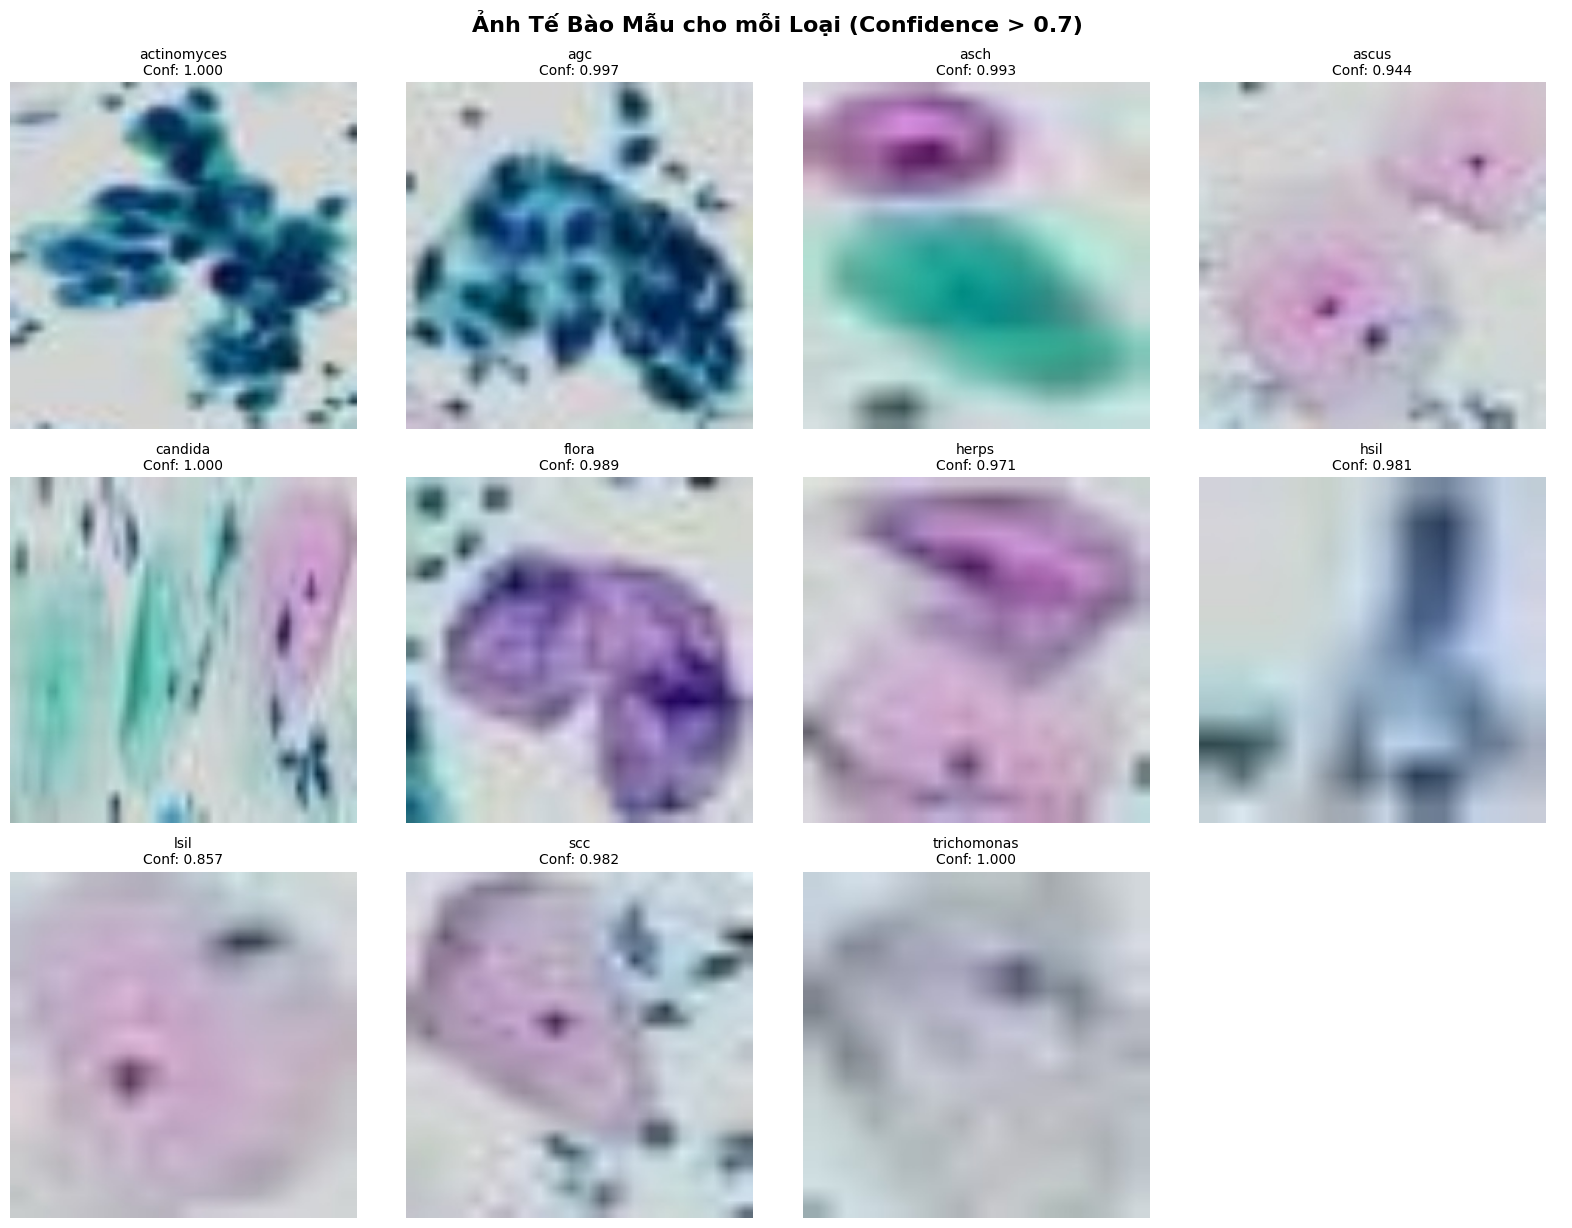

✅ Đã hiển thị 11 ảnh mẫu cho các loại tế bào với confidence > 0.7.


In [23]:
import matplotlib.pyplot as plt
import cv2
import os
from collections import defaultdict

# Đổi từ 'results' sang 'res' để lấy kết quả từ xử lý SVS
if 'res' in locals() and len(res) > 0:
    print('🔬 Hiển thị một ảnh mẫu cho mỗi loại tế bào (Confidence > 0.7):')

    # Dictionary để lưu ảnh mẫu cho mỗi label
    sample_images_by_label = defaultdict(list)

    # Lọc kết quả với confident > 0.7
    filtered_res = [r for r in res if r['confidence'] > 0.7]

    # Lấy ảnh mẫu cho mỗi label từ các kết quả đã lọc
    for r in filtered_res:
        label = r['label']
        status = r['status']
        cell_id = r['cell_id']
        conf = r['confidence']

        img_path = None
        if status == 'abnormal':
            img_path = f'./svs_ultra_fast/cells/{cell_id}_{label}.jpg'
        # Với pipeline SVS nhanh, chúng ta chỉ lưu ảnh 'abnormal'.
        # Để hiển thị 'uncertain' hoặc 'normal', hàm process_svs_ultra_fast cần được chỉnh sửa để lưu các ảnh đó.

        if img_path and os.path.exists(img_path):
            # Chỉ cần một ảnh mẫu cho mỗi label, ưu tiên cái có confidence cao hơn nếu đã có
            if label not in sample_images_by_label or conf > sample_images_by_label[label]['confidence']:
                sample_images_by_label[label] = {'path': img_path, 'label': label, 'confidence': conf}

    if len(sample_images_by_label) > 0:
        # Sắp xếp các label để hiển thị nhất quán
        sorted_labels = sorted(sample_images_by_label.keys())

        # Giới hạn số lượng ảnh hiển thị để tránh quá tải
        max_display = min(12, len(sorted_labels))

        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        axes = axes.flatten()

        for idx, label in enumerate(sorted_labels[:max_display]):
            cell_info = sample_images_by_label[label]
            img_path = cell_info['path']

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[idx].imshow(img)
            axes[idx].set_title(f'{label}\nConf: {cell_info["confidence"]:.3f}', fontsize=10)
            axes[idx].axis('off')

        # Ẩn các subplot trống nếu số lượng label ít hơn 12
        for idx in range(max_display, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.suptitle('Ảnh Tế Bào Mẫu cho mỗi Loại (Confidence > 0.7)', fontsize=16, fontweight='bold', y=1.02)
        plt.show()

        print(f'✅ Đã hiển thị {max_display} ảnh mẫu cho các loại tế bào với confidence > 0.7.')
    else:
        print('❌ Không tìm thấy ảnh tế bào mẫu nào có confidence > 0.7 để hiển thị.')
else:
    print('❌ Không có kết quả phân loại nào để hiển thị ảnh mẫu.')

In [ ]:
def load_images_from_folders(images_dir, label_map, target_size=128):
    """
    Load images from folder structure:
    images_dir/
        1/  (ascus)
            image1.jpg
            image2.jpg
        2/  (asch)
            image3.jpg
        ...
    """
    all_images = []
    all_labels = []

    print(f'🔄 Loading images from {images_dir}...')

    # Iterate through each class folder
    for class_id in sorted(label_map.keys()):
        class_name = label_map[class_id]
        class_dir = os.path.join(images_dir, str(class_id))

        if not os.path.exists(class_dir):
            print(f'⚠️  Folder not found: {class_dir}')
            continue

        # Get all image files in this class folder
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.PNG']:
            image_files.extend(Path(class_dir).glob(ext))

        print(f'\nLoading Class {class_id} ({class_name}): {len(image_files)} images')

        # Load each image
        for img_path in image_files:
            try:
                # Load image
                img = Image.open(img_path).convert('RGB')

                # Resize
                img = img.resize((target_size, target_size))

                # Convert to numpy - NO NORMALIZATION (model will do it)
                img_array = np.array(img, dtype=np.float32)

                all_images.append(img_array)
                all_labels.append(class_id)
            except Exception as e:
                print(f'  ❌ Error loading {img_path}: {e}')

    # Convert to numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels)

    print(f'\n✅ Total images loaded: {len(all_images)}')

    if len(all_images) > 0:
        print(f'📊 Dataset shape: X={X.shape}, y={y.shape}')
        print(f'📊 Pixel range: [{X.min():.1f}, {X.max():.1f}]')

        # Print class distribution
        print(f'\n📊 Class distribution:')
        unique, counts = np.unique(y, return_counts=True)
        for cls, cnt in zip(unique, counts):
            print(f'   Class {cls:2d} ({label_map.get(cls, "unknown"):15s}): {cnt:4d} samples')
    else:
        print('⚠️ No images found. Returning empty arrays.')

    return X, y

# Define images_dir with a suitable path, for example:
images_dir = '/content/drive/MyDrive/PhatHienTeBao/images'  # Đường dẫn thư mục ảnh trên Google Drive

# Load all images (224x224 for better transfer learning)
X, y = load_images_from_folders(images_dir, label_map, target_size=224)

🔄 Loading images from /content/drive/MyDrive/ComparisonDetector/AIDetect/images...
⚠️  Folder not found: /content/drive/MyDrive/ComparisonDetector/AIDetect/images/0

Loading Class 1 (ascus): 141 images

Loading Class 2 (asch): 139 images

Loading Class 3 (lsil): 143 images

Loading Class 4 (hsil): 149 images

Loading Class 5 (scc): 147 images

Loading Class 6 (agc): 148 images

Loading Class 7 (trichomonas): 130 images

Loading Class 8 (candida): 144 images

Loading Class 9 (flora): 147 images

Loading Class 10 (herps): 142 images

Loading Class 11 (actinomyces): 133 images

✅ Total images loaded: 1563
📊 Dataset shape: X=(1563, 224, 224, 3), y=(1563,)
📊 Pixel range: [0.0, 255.0]

📊 Class distribution:
   Class  1 (ascus          ):  141 samples
   Class  2 (asch           ):  139 samples
   Class  3 (lsil           ):  143 samples
   Class  4 (hsil           ):  149 samples
   Class  5 (scc            ):  147 samples
   Class  6 (agc            ):  148 samples
   Class  7 (trichomonas 

In [ ]:
import os
import cv2
import numpy as np
import json
import time
import gc
import concurrent.futures
from openslide import OpenSlide
import tensorflow as tf

# --- CẤU HÌNH ---
if 'ABNORMAL_CONFIDENCE_THRESHOLD' not in locals():
    ABNORMAL_CONFIDENCE_THRESHOLD = 0.7

if 'label_map' not in locals():
    label_map = {
        0: "back_ground", 1: 'ascus', 2: 'asch', 3: 'lsil', 4: 'hsil',
        5: 'scc', 6: 'agc', 7: 'trichomonas', 8: 'candida', 9: 'flora',
        10: 'herps', 11: 'actinomyces',
    }

# Mixed Precision
try:
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print('🚀 Mixed Precision (float16) enabled.')
except:
    pass

def detect_cells_smart_fast(image, min_area=5, max_area=5000):
    """
    🚀 SMART FAST DETECTOR
    Sáng tạo: Sử dụng CLAHE (Contrast Limited Adaptive Histogram Equalization)
    để làm nổi bật tế bào trước khi threshold.

    Ưu điểm:
    - Nhanh hơn Combo rất nhiều (chỉ 1 pass).
    - Chính xác hơn Basic (bắt được tế bào mờ).
    """
    # 1. Chuyển Gray
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # 2. Tăng tương phản thông minh (CLAHE) - Key point
    # ClipLimit=2.0 giúp nổi bật chi tiết mà không quá nhiễu
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # 3. Làm mờ nhẹ để giảm noise hạt
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

    # 4. Otsu Threshold (Tự động tìm ngưỡng tối ưu)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 5. Lọc nhiễu Morphological (Mở rộng vùng chọn)
    kernel = np.ones((3, 3), np.uint8)
    # Morphology Open: Xóa nhiễu nhỏ
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # 6. Find Contours
    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cells = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            x, y, w, h = cv2.boundingRect(contour)
            # Tính tâm đơn giản
            cx, cy = x + w//2, y + h//2
            cells.append({
                'bbox': (x, y, w, h),
                'center': (cx, cy),
                'area': area
            })
    return cells

def process_svs_ultra_fast(svs_path, classification_model,
                           process_level=2,
                           chunk_size=2048,
                           input_size=224,
                           tissue_thresh=230,
                           max_time_sec=300,
                           output_dir='./svs_ultra_fast'):
    """
    Pipeline siêu tốc (Parallel Mode) với Smart Detector
    Sử dụng ThreadPoolExecutor để đọc và detect song song.
    """
    gc.collect()
    os.makedirs(f'{output_dir}/cells', exist_ok=True)
    os.makedirs(f'{output_dir}/uncertain', exist_ok=True)

    slide = OpenSlide(svs_path)
    start_time = time.time()

    # --- 1. INSTANT MASKING ---
    print(f'⏱️  Generating Instant Mask from thumbnail...')
    thumb = slide.get_thumbnail((512, 512)).convert('RGB')
    thumb_np = np.array(thumb)
    w_thumb, h_thumb = thumb.size

    gray_mask = cv2.cvtColor(thumb_np, cv2.COLOR_RGB2GRAY)
    tissue_mask = (gray_mask < tissue_thresh)

    if process_level >= slide.level_count: process_level = slide.level_count - 1
    w_lvl, h_lvl = slide.level_dimensions[process_level]

    scale_x = w_lvl / w_thumb
    scale_y = h_lvl / h_thumb

    # --- 2. LẬP DANH SÁCH CHUNKS ---
    chunks_to_process = []
    for y in range(0, h_lvl, chunk_size):
        for x in range(0, w_lvl, chunk_size):
            tx = int(x / scale_x)
            ty = int(y / scale_y)
            tw = int(chunk_size / scale_x) + 1
            th = int(chunk_size / scale_y) + 1
            roi = tissue_mask[ty:ty+th, tx:tx+tw]
            if np.any(roi):
                chunks_to_process.append((x, y))

    print(f'✅ Found {len(chunks_to_process)} large chunks with tissue.')
    print(f'🚀 Processing Level {process_level} | Chunk: {chunk_size}x{chunk_size}')
    print(f'✨ Using Smart Fast Detector (CLAHE + Otsu) in PARALLEL mode')

    # --- 3. HÀM WORKER CHO THREAD POOL ---
    def process_chunk_worker(coords):
        x, y = coords
        try:
            # OpenSlide handles are thread-safe for reading
            rw = min(chunk_size, w_lvl - x)
            rh = min(chunk_size, h_lvl - y)
            down = slide.level_downsamples[process_level]
            x0, y0 = int(x * down), int(y * down)

            # Đọc vùng ảnh (I/O Bound)
            region = slide.read_region((x0, y0), process_level, (rw, rh))
            chunk_rgb = np.array(region.convert('RGB'))

            # Detect (CPU Bound - but OpenCV releases GIL)
            cells = detect_cells_smart_fast(chunk_rgb, min_area=5, max_area=5000)

            crop_results = []
            for c in cells:
                cx, cy, cw, ch = c['bbox']
                if cw < 8 or ch < 8: continue

                # Crop
                crop = chunk_rgb[cy:cy+ch, cx:cx+cw]
                if crop.size == 0: continue

                # Resize
                cr = cv2.resize(crop, (input_size, input_size))

                # Lưu metadata cần thiết
                crop_results.append({
                    'img': cr,
                    'abs_x': x + cx,
                    'abs_y': y + cy
                })

            return crop_results
        except Exception as e:
            return []

    # --- 4. XỬ LÝ SONG SONG VÀ DỰ ĐOÁN BATCH ---
    all_results = []
    cell_id = 0

    batch_img = []
    batch_meta = []
    SAFE_BATCH_SIZE = 32 # Tăng batch size vì xử lý nhanh hơn

    # Sử dụng ThreadPoolExecutor
    # Tăng lên 6 workers theo yêu cầu
    with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
        # Submit tất cả các chunks
        future_to_chunk = {executor.submit(process_chunk_worker, c): c for c in chunks_to_process}

        print(f'🧵 Started 6 worker threads. Processing...')

        completed_count = 0
        for future in concurrent.futures.as_completed(future_to_chunk):
            if time.time() - start_time > max_time_sec:
                print(f'⏰ Time limit ({max_time_sec}s) reached. Stopping early.')
                executor.shutdown(wait=False)
                break

            try:
                crops = future.result()

                # Gom vào batch
                for item in crops:
                    batch_img.append(item['img'].astype(np.float32))
                    batch_meta.append(item)

                # Chạy model nếu batch đầy
                while len(batch_img) >= SAFE_BATCH_SIZE:
                    # Lấy batch
                    curr_img = np.array(batch_img[:SAFE_BATCH_SIZE])
                    curr_meta = batch_meta[:SAFE_BATCH_SIZE]

                    # Xóa khỏi hàng đợi
                    batch_img = batch_img[SAFE_BATCH_SIZE:]
                    batch_meta = batch_meta[SAFE_BATCH_SIZE:]

                    # Predict (GPU)
                    input_t = tf.convert_to_tensor(curr_img)
                    preds = classification_model(input_t, training=False).numpy()

                    # Xử lý kết quả
                    for j, info in enumerate(curr_meta):
                        p = preds[j]
                        p_cls = int(np.argmax(p))
                        p_conf = float(p[p_cls])
                        label = label_map.get(p_cls, str(p_cls))

                        status = 'normal'
                        is_abn = False

                        # LOGIC LỌC: Chỉ background(0) là bỏ qua
                        if p_cls != 0:
                            if p_conf >= ABNORMAL_CONFIDENCE_THRESHOLD:
                                status = 'abnormal'
                                is_abn = True
                            else:
                                status = 'uncertain'

                        res = {
                            'cell_id': cell_id,
                            'x': info['abs_x'], 'y': info['abs_y'],
                            'class': p_cls, 'label': label, 'confidence': p_conf,
                            'status': status, 'is_truly_abnormal': is_abn
                        }
                        all_results.append(res)

                        if is_abn:
                            # Lưu ảnh (convert RGB -> BGR)
                            cv2.imwrite(f'{output_dir}/cells/{cell_id}_{label}.jpg',
                                        cv2.cvtColor(curr_img[j], cv2.COLOR_RGB2BGR))

                        cell_id += 1
            except Exception as e:
                print(f'⚠️ Error in thread: {e}')

            completed_count += 1
            if completed_count % 5 == 0:
                print(f'   Processed {completed_count}/{len(chunks_to_process)} chunks | Found {len(all_results)} cells | {time.time()-start_time:.0f}s')

        # Xử lý phần còn lại trong batch (nếu có)
        if len(batch_img) > 0:
            curr_img = np.array(batch_img)
            input_t = tf.convert_to_tensor(curr_img)
            preds = classification_model(input_t, training=False).numpy()

            for j, info in enumerate(batch_meta):
                p = preds[j]
                p_cls = int(np.argmax(p))
                p_conf = float(p[p_cls])
                label = label_map.get(p_cls, str(p_cls))

                status = 'normal'
                is_abn = False
                if p_cls != 0:
                    if p_conf >= ABNORMAL_CONFIDENCE_THRESHOLD:
                        status = 'abnormal'
                        is_abn = True
                    else:
                        status = 'uncertain'

                res = {
                    'cell_id': cell_id,
                    'x': info['abs_x'], 'y': info['abs_y'],
                    'class': p_cls, 'label': label, 'confidence': p_conf,
                    'status': status, 'is_truly_abnormal': is_abn
                }
                all_results.append(res)
                if is_abn:
                    cv2.imwrite(f'{output_dir}/cells/{cell_id}_{label}.jpg',
                                cv2.cvtColor(curr_img[j], cv2.COLOR_RGB2BGR))
                cell_id += 1

    slide.close()

    with open(f'{output_dir}/results_ultra.json', 'w', encoding='utf-8') as f:
        json.dump(all_results, f, ensure_ascii=False)

    print(f'\n🏁 FINISHED in {time.time()-start_time:.1f}s. Total cells: {len(all_results)}')
    return all_results

# CHẠY NGAY (Reload model để fix lỗi session cũ)
svs_path = '/content/drive/MyDrive/PhatHienTeBao/sample.svs'  # Đường dẫn file SVS trên Google Drive
model_path = '/content/drive/MyDrive/PhatHienTeBao/best_cytology_model.keras'  # Đường dẫn model trên Google Drive

if os.path.exists(svs_path):
    # Force Clean & Reload
    tf.keras.backend.clear_session()
    gc.collect()

    if os.path.exists(model_path):
        print('🔄 Reloading model to ensure clean state...')
        classification_model = tf.keras.models.load_model(model_path)

        res = process_svs_ultra_fast(
            svs_path=svs_path,
            classification_model=classification_model,
            process_level=2,
            chunk_size=2048,
            max_time_sec=10000
        )
    else:
        print(f'❌ Model not found: {model_path}')
else:
    print(f'❌ File not found: {svs_path}')

🚀 Mixed Precision (float16) enabled.
🔄 Reloading model to ensure clean state...
⏱️  Generating Instant Mask from thumbnail...
✅ Found 12 large chunks with tissue.
🚀 Processing Level 2 | Chunk: 2048x2048
✨ Using Smart Fast Detector (CLAHE + Otsu) in PARALLEL mode
🧵 Started 6 worker threads. Processing...
   Processed 5/12 chunks | Found 2272 cells | 46s
   Processed 10/12 chunks | Found 12736 cells | 211s

🏁 FINISHED in 241.8s. Total cells: 14672
